## Load modules

In [1]:
push!(LOAD_PATH, "../dvi/src")

addprocs(int(CPU_CORES / 2))

using DiscreteValueIteration
using SCAs, SCAIterators, SCAConst
using GridInterpolations

mdp = SCA()

SCA(5446,36,StateIterator([-2000.0,-1600.0,-1200.0,-800.0,-400.0,0.0,400.0,800.0,1200.0,1600.0,2000.0],[-2000.0,-1600.0,-1200.0,-800.0,-400.0,0.0,400.0,800.0,1200.0,1600.0,2000.0],[0.0,1.5708,3.14159,4.71239,6.28319],[10.0,15.0,20.0],[10.0,15.0,20.0],1,1,1,1,1,5446),ActionIterator([:right20,:right10,:straight,:left10,:left20,:clearOfConflict],1,1,36),RectangleGrid with 5445 points)

## Check size of MDP

In [2]:
function getBytes(x)
   total = 0;
   fieldNames = typeof(x).names;
   if fieldNames == ()
      return sizeof(x);
   else
     for fieldName in fieldNames
        total += getBytes(getfield(x,fieldName));
     end
     return total;
   end
end

println("mdp of type ", typeof(mdp), " takes up ", getBytes(mdp) / 1000.0, " kB")

mdp of type SCA takes up 1.768 kB


## Informal validation of state and action iterators and transition function

In [3]:
testActions = ActionIterator(Actions)
actionCount = 0
for action in testActions
    actionCount += 1
    if actionCount == 1 || actionCount == NActions
        println("action #", actionCount, ": ", typeof(action), " = ", action)
    end # if
end # for action
println("nActions = ", NActions)
println("actionCount = ", actionCount)

testStates = StateIterator(Xs, Ys, Bearings, Speeds, Speeds)
stateCount = 0
for state in testStates
    stateCount += 1
    if stateCount == 1 || stateCount == NStates
        println("state #", stateCount, ": ", typeof(state), " = ", state)
    end # if
end # for state
println("nStates = ", NStates)
println("stateCount = ", stateCount)

action #1: Action = Action(:right20,:right20)
action #36: Action = Action(:clearOfConflict,:clearOfConflict)
nActions = 36
actionCount = 36
state #1: State = State(-2000.0,-2000.0,0.0,10.0,10.0,false)
state #5446: State = State(-2000.0,-2000.0,0.0,10.0,10.0,true)
nStates = 5446
stateCount = 5446


In [4]:
newStates, probs = nextStates(mdp, State(0.0,0.0,0.0,13.0,14.0,false), Action(:straight, :straight))
println(newStates)

[State(-2000.0,-2000.0,0.0,10.0,10.0,false),State(-1600.0,-2000.0,0.0,10.0,10.0,false),State(-1200.0,-2000.0,0.0,10.0,10.0,false),State(-800.0,-2000.0,0.0,10.0,10.0,false),State(-400.0,-2000.0,0.0,10.0,10.0,false),State(0.0,-2000.0,0.0,10.0,10.0,false),State(400.0,-2000.0,0.0,10.0,10.0,false),State(800.0,-2000.0,0.0,10.0,10.0,false)]


## Parallel solution

In [10]:
numProcs = int(CPU_CORES / 2)
solver = ParallelSolver(
    numProcs,
    maxIterations = 1000,
    tolerance = 1e-6,
    gaussSiedel = false,
    includeV = true,
    includeQ = true,
    includeA = true)

ParallelSolver(2,None[],1000,1.0e-6,false,true,true,true)

In [11]:
policy = solve(solver, mdp, verbose = true)
println("")

Iter 1: resid = 1.020e+06, run-time = 3.956e+00, net runtime = 3.956e+00
Iter 2: resid = 9.206e+05, run-time = 4.005e+00, net runtime = 7.961e+00
Iter 3: resid = 6.583e+05, run-time = 3.917e+00, net runtime = 1.188e+01
Iter 4: resid = 4.050e+05, run-time = 3.872e+00, net runtime = 1.575e+01
Iter 5: resid = 2.161e+05, run-time = 3.949e+00, net runtime = 1.970e+01
Iter 6: resid = 1.198e+05, run-time = 3.947e+00, net runtime = 2.365e+01
Iter 7: resid = 6.659e+04, run-time = 4.022e+00, net runtime = 2.767e+01
Iter 8: resid = 3.713e+04, run-time = 4.016e+00, net runtime = 3.168e+01
Iter 9: resid = 2.067e+04, run-time = 3.929e+00, net runtime = 3.561e+01
Iter 10: resid = 1.150e+04, run-time = 3.982e+00, net runtime = 3.960e+01
Iter 11: resid = 6.410e+03, run-time = 3.970e+00, net runtime = 4.357e+01
Iter 12: resid = 3.577e+03, run-time = 3.873e+00, net runtime = 4.744e+01
Iter 13: resid = 2.000e+03, run-time = 3.937e+00, net runtime = 5.138e+01
Iter 14: resid = 1.108e+03, run-time = 3.928e+0

## Check against reference solution by visual inspection

In [17]:
push!(LOAD_PATH, "../src/")
using Pairwise, Multiagent, HDF5, JLD

d = get_pomdp()
refQ = load("../data/alpha.jld", "alpha")
solQ = policy.Q'
save("../data/par-alpha.jld", "solQ", solQ)

### Reference policy plot

Slider{Float64}([Input{Float64}] 180.0,"p",180.0,0.0:90.0:360.0)

Slider{Float64}([Input{Float64}] 15.0,"v0",15.0,10.0:5.0:20.0)

Slider{Float64}([Input{Float64}] 15.0,"v1",15.0,10.0:5.0:20.0)

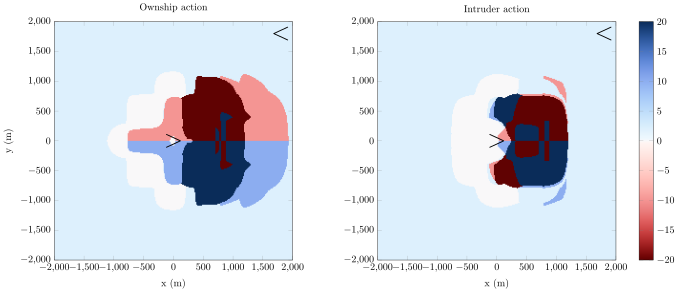

In [18]:
viz_pairwise_policy(d, refQ)

### Parallel solver policy plot

Note: We haven't implemented sigma-sampling.

In [24]:
function sharray2array(sharray::SharedArray{Float64, 2})
    result = zeros(solQ.dims)
    for i = 1:solQ.dims[1]
        for j = 1:solQ.dims[2]
            result[i, j] = sharray[i, j]
        end # for j
    end # for i
    return result
end # function sharray2array

sharray2array (generic function with 1 method)

Slider{Float64}([Input{Float64}] 180.0,"p",180.0,0.0:90.0:360.0)

Slider{Float64}([Input{Float64}] 15.0,"v0",15.0,10.0:5.0:20.0)

Slider{Float64}([Input{Float64}] 15.0,"v1",15.0,10.0:5.0:20.0)

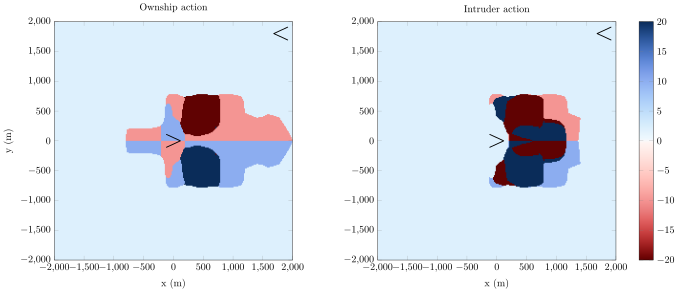

In [25]:
viz_pairwise_policy(d, sharray2array(solQ))